In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
import sqlite3 as sl
from sklearn.preprocessing import MinMaxScaler

# suppress warnings
import warnings
warnings.filterwarnings("ignore")


con = sl.connect(r'C:\CODE\learning\Apex_cluster\database\apex.db')
df = pd.read_sql("select * from api_rank_s13",con)

In [2]:
# drop nans for kills and zeros
df = df.dropna(subset=['kills', 'level'])
df = df[df['kills'] != 0]

# drop players in rookie rank
df = df[df['rank'] != 'Rookie']
print(len(df))
df.isnull().sum()

1121


uid                 0
username            0
level               0
rankscore           0
rank                0
skin                0
skinrarity          0
kd                  0
kills               0
damage            406
top_3            1007
games_played      917
date_accessed       0
dtype: int64

Log transforming/Scaling (min/max) kills and level to put both variables on the same scale and remove skewness

NormaltestResult(statistic=65.60353303791486, pvalue=5.6803331032577455e-15)


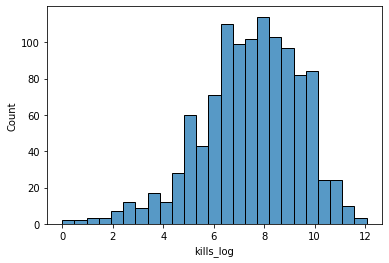

In [3]:
df['kills_log'] = np.log(df['kills'])
sns.histplot(data = df, x ='kills_log')
print(stats.normaltest(df['kills_log']))

NormaltestResult(statistic=47.41567735567249, pvalue=5.056109656999829e-11)


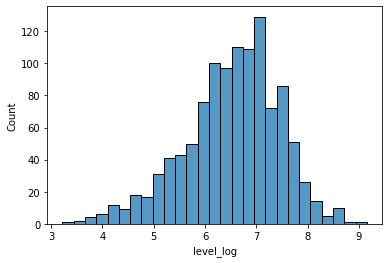

In [4]:
df['level_log'] = np.log(df['level'])
sns.histplot(data = df, x ='level_log')
print(stats.normaltest(df['level_log']))

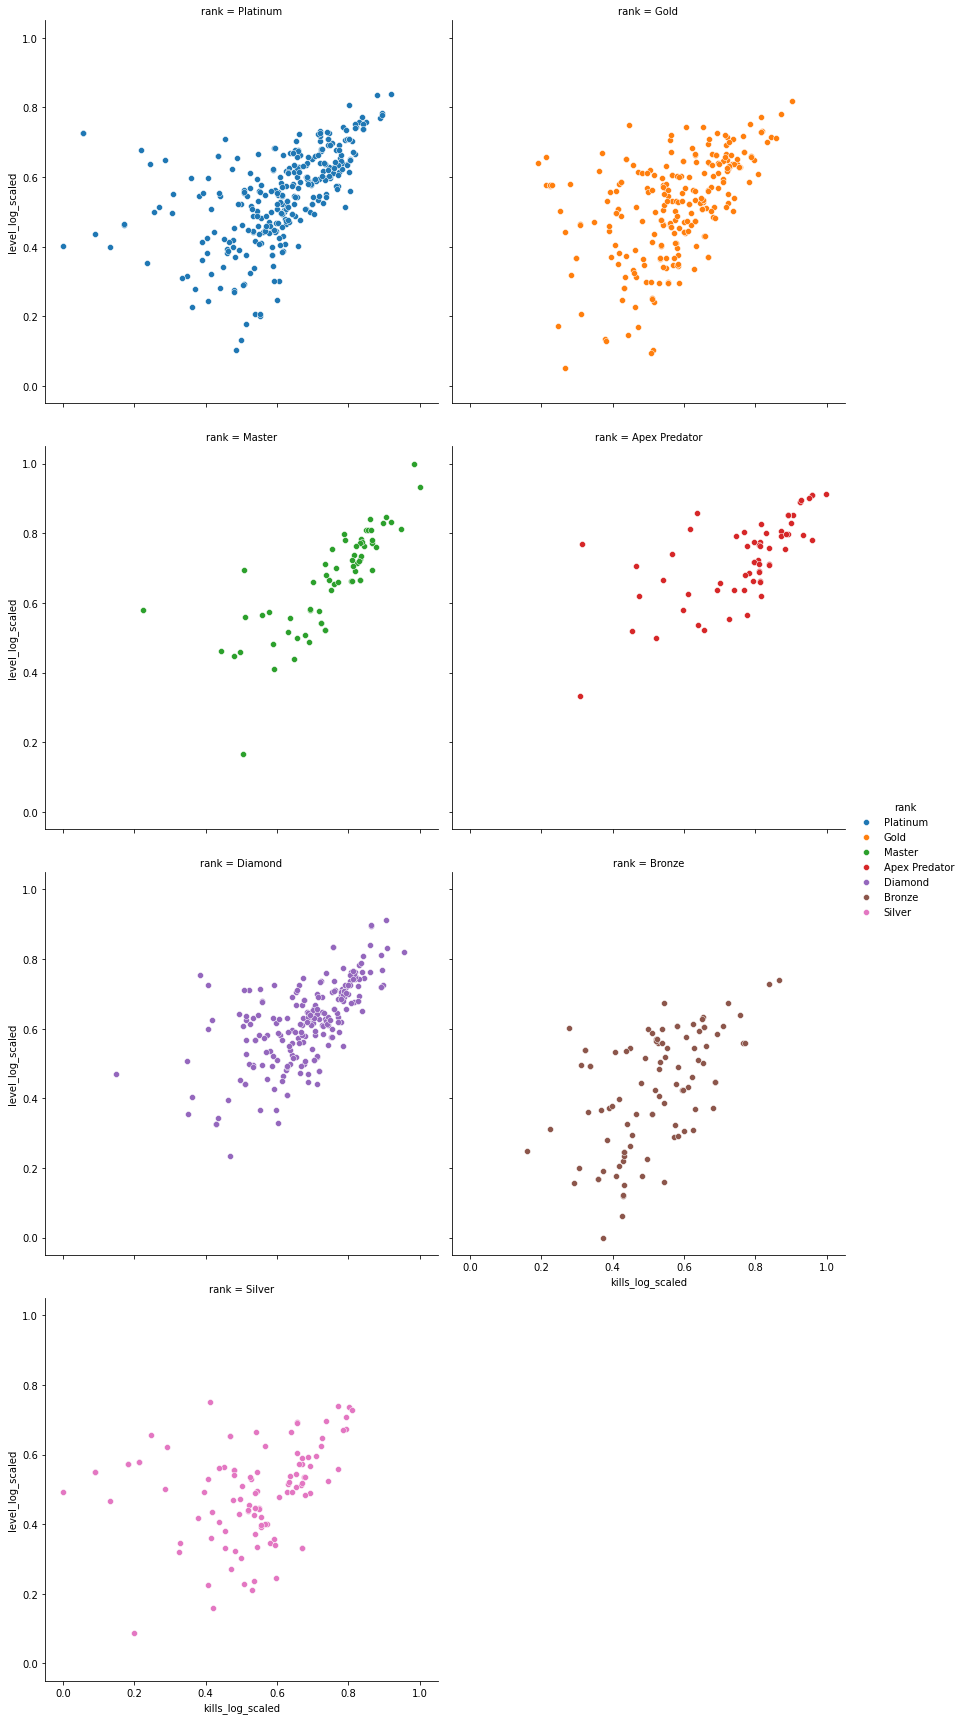

In [5]:
scaler = MinMaxScaler()
df['kills_scaled'] = scaler.fit_transform(df[['kills']])
df['level_scaled'] = scaler.fit_transform(df[['level']])
df['level_log_scaled'] = scaler.fit_transform(df[['level_log']])
df['kills_log_scaled'] = scaler.fit_transform(df[['kills_log']])


g = sns.FacetGrid(df, col="rank", hue="rank", col_wrap=2, size=6)
g.map_dataframe(sns.scatterplot, x="kills_log_scaled", y="level_log_scaled")
g.add_legend()

Creating variable by dividing kills by level

In [6]:
df['kill_per_level'] = df['kills']/df['level']
averages = df.groupby('rank')['kill_per_level'].median()
print(averages)

rank
Apex Predator    9.648574
Bronze           1.930556
Diamond          4.547315
Gold             2.792793
Master           9.161366
Platinum         3.441084
Silver           2.153409
Name: kill_per_level, dtype: float64


Using Mann-whitney test to identify if there are significant differences in kills_per_level between ranks 

In [8]:
stats.mannwhitneyu(df['kill_per_level'][df['rank'] == 'Silver'], df['kill_per_level'][df['rank'] == 'Master'])

MannwhitneyuResult(statistic=1344.0, pvalue=8.323489709827528e-12)

Attempting to cluster using n_clusters = n_ranks

In [9]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(df[['kills_log_scaled', 'level_log_scaled']])
df['cluster'] = kmeans.labels_
df['cluster'] = df['cluster'].astype('category')
df['cluster'].value_counts()

5    270
4    205
6    184
1    163
2    151
0     98
3     50
Name: cluster, dtype: int64

Determining optimal number of clusters using elbow method and silhouette score

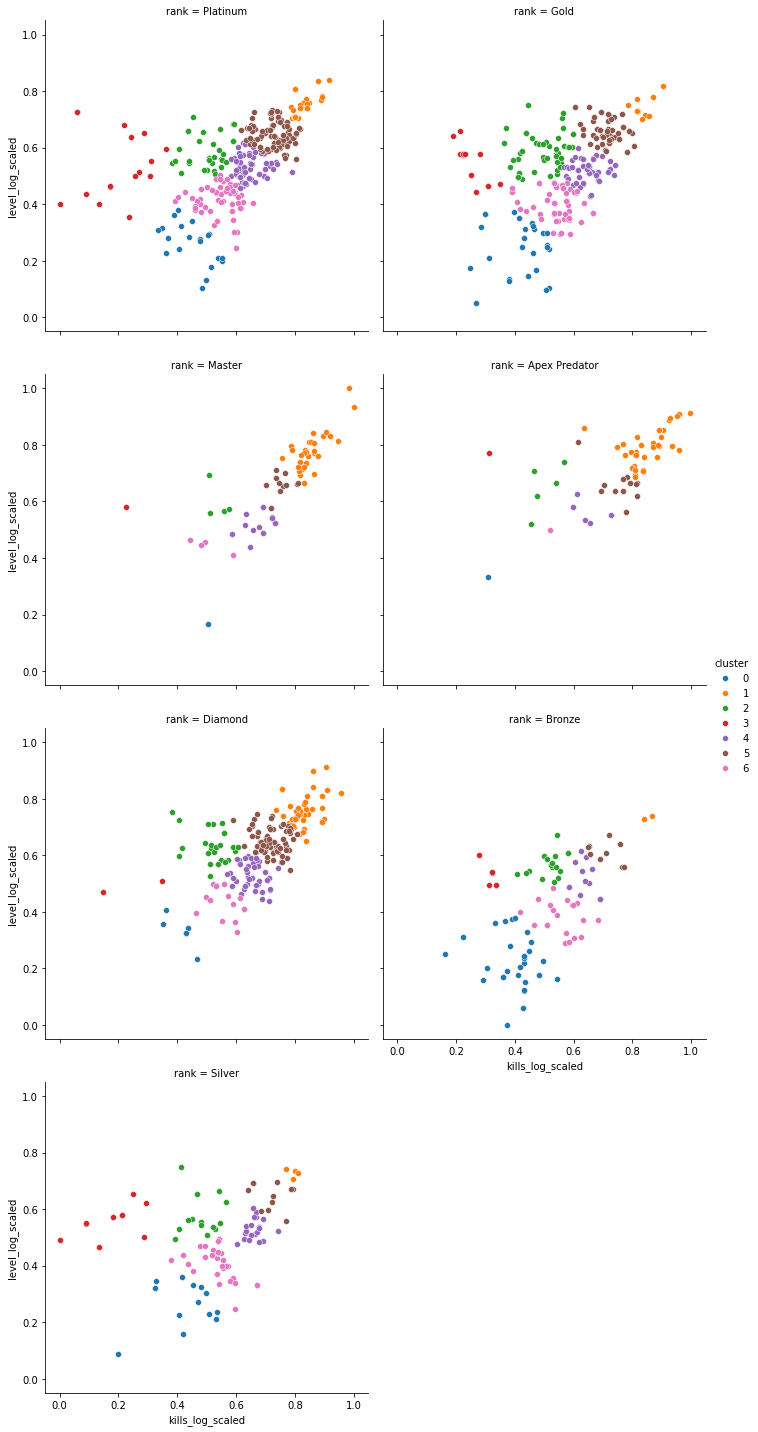

In [10]:
g = sns.FacetGrid(df, col="rank", hue="cluster", col_wrap=2, size=5)
g.map_dataframe(sns.scatterplot, x="kills_log_scaled", y="level_log_scaled")
g.add_legend()

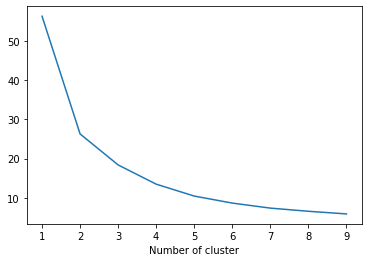

In [11]:
# elbow method
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df[['kills_log_scaled', 'level_log_scaled']])
    df["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

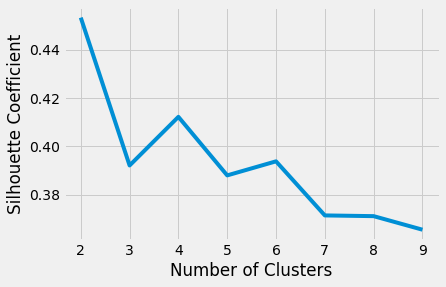

In [12]:
# silhouette score
from sklearn.metrics import silhouette_score
silhouette_coefficients = []

# silhouette coefficient
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000)
    kmeans.fit(df[['kills_log_scaled', 'level_log_scaled']])
    score = silhouette_score(df[['kills_log_scaled', 'level_log_scaled']], kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 10), silhouette_coefficients)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Optimal clusters somewhere between 2 and 4, trying spectral clustering for better performance


In [15]:
#  spectral clustering
from sklearn.cluster import SpectralClustering
clustering = SpectralClustering(n_clusters=3, random_state=0).fit(df[['kills_log_scaled', 'level_log_scaled']])
df['cluster'] = clustering.labels_
df['cluster'] = df['cluster'].astype('category')
df['cluster'].value_counts()

2    565
0    381
1    175
Name: cluster, dtype: int64

Overall clustering performance seems poor, however 3 clusters seems to identify meaningful seperations in the data

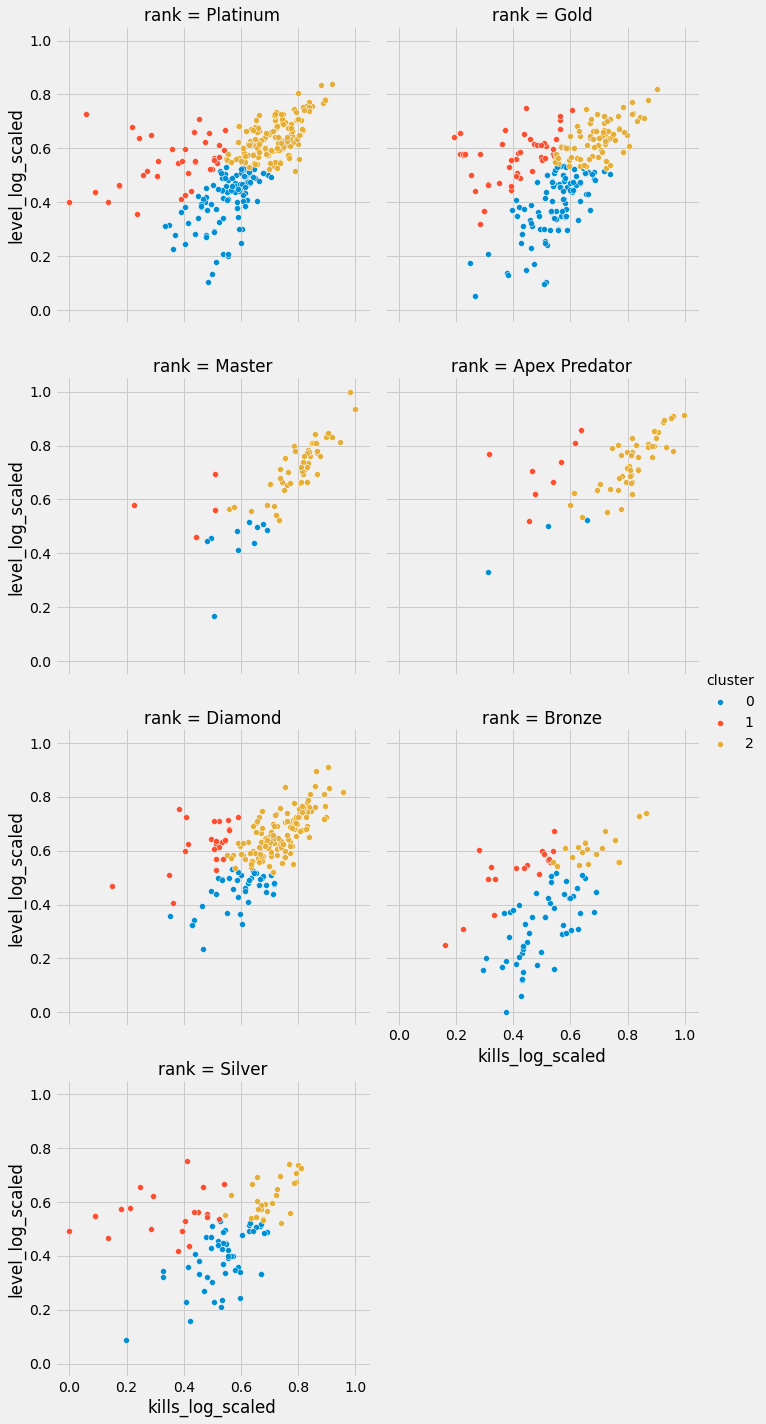

In [16]:
g = sns.FacetGrid(df, col="rank", hue="cluster", col_wrap=2, size=5)
g.map_dataframe(sns.scatterplot, x="kills_log_scaled", y="level_log_scaled")
g.add_legend()

Moving on to classification techniques (multiclass) using rank and clusters from spectral clustering

In [17]:
# multinomial logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss

# split data into train and test
X = df[['kills_log_scaled', 'level_log_scaled']]
# X = df[['kill_per_level']]
y = df['rank']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# multinomial logistic regression
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred))
print('Classification Report: ', classification_report(y_test, y_pred))
# print('Log Loss: ', log_loss(y_test, y_pred))

Accuracy:  0.27555555555555555
Confusion Matrix:  [[ 0  0 13  0  0  1  0]
 [ 0  1  0  9  0 17  0]
 [ 0  0 12  5  0 10  0]
 [ 0  0 11 13  0 30  0]
 [ 0  0 11  1  0  3  0]
 [ 0  0 24  7  0 36  0]
 [ 0  0  3  7  0 11  0]]
Classification Report:                 precision    recall  f1-score   support

Apex Predator       0.00      0.00      0.00        14
       Bronze       1.00      0.04      0.07        27
      Diamond       0.16      0.44      0.24        27
         Gold       0.31      0.24      0.27        54
       Master       0.00      0.00      0.00        15
     Platinum       0.33      0.54      0.41        67
       Silver       0.00      0.00      0.00        21

     accuracy                           0.28       225
    macro avg       0.26      0.18      0.14       225
 weighted avg       0.31      0.28      0.22       225



In [18]:
#  knn classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred))
print('Classification Report: ', classification_report(y_test, y_pred))
# print('Log Loss: ', log_loss(y_test, y_pred))

Accuracy:  0.28
Confusion Matrix:  [[ 3  0  7  0  1  2  1]
 [ 0  7  3  9  0  7  1]
 [ 0  2  9  5  2  7  2]
 [ 1  8 11 20  3 10  1]
 [ 2  0  5  1  2  4  1]
 [ 2  3 21 13  3 21  4]
 [ 1  3  3  9  0  4  1]]
Classification Report:                 precision    recall  f1-score   support

Apex Predator       0.33      0.21      0.26        14
       Bronze       0.30      0.26      0.28        27
      Diamond       0.15      0.33      0.21        27
         Gold       0.35      0.37      0.36        54
       Master       0.18      0.13      0.15        15
     Platinum       0.38      0.31      0.34        67
       Silver       0.09      0.05      0.06        21

     accuracy                           0.28       225
    macro avg       0.26      0.24      0.24       225
 weighted avg       0.29      0.28      0.28       225



Performance is poor for both models using rank as dependent variable, relatively good performance when using cluster as dependent variable

In [19]:
# split data into train and test
X = df[['kills_log_scaled', 'level_log_scaled']]
# X = df[['kill_per_level']]
y = df['cluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# multinomial logistic regression
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred))
print('Classification Report: ', classification_report(y_test, y_pred))
# print('Log Loss: ', log_loss(y_test, y_pred))

Accuracy:  0.9288888888888889
Confusion Matrix:  [[ 81   0   6]
 [  6  22   4]
 [  0   0 106]]
Classification Report:                precision    recall  f1-score   support

           0       0.93      0.93      0.93        87
           1       1.00      0.69      0.81        32
           2       0.91      1.00      0.95       106

    accuracy                           0.93       225
   macro avg       0.95      0.87      0.90       225
weighted avg       0.93      0.93      0.93       225



In [20]:
#  knn classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred))
print('Classification Report: ', classification_report(y_test, y_pred))
# print('Log Loss: ', log_loss(y_test, y_pred))

Accuracy:  0.9688888888888889
Confusion Matrix:  [[ 85   1   1]
 [  3  29   0]
 [  0   2 104]]
Classification Report:                precision    recall  f1-score   support

           0       0.97      0.98      0.97        87
           1       0.91      0.91      0.91        32
           2       0.99      0.98      0.99       106

    accuracy                           0.97       225
   macro avg       0.95      0.95      0.95       225
weighted avg       0.97      0.97      0.97       225

